In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

torch.manual_seed(42)
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device= torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
print(type(trainset))
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "Glioma",
    "Meningioma",
    "No Tumor",
    "Pituitary",
)

<class 'torchvision.datasets.cifar.CIFAR10'>


In [3]:
import ImageLoader as im
path = "C:\\Users\\ruihe\\Quantom-Nural-Network\\ALL DATA"

# extracts images
x_r, y_r = im.ImageLoader(path, 583, 2,["Pituitary","Meningioma","No Tumor","Glioma"])
# print(y_r.shape)
x_raw = x_r[0:2000]
y_raw = y_r[0:2000]
x_Test = x_r[2000:2333]
y_Test = y_r[2000:2333]

# for y in y_raw:
#     if y!=0 and y!=1:
#         print(y)

x_raw_tensor = torch.from_numpy(x_raw.astype(np.float32))
y_raw_tensor = torch.from_numpy(y_raw)
print(y_raw_tensor.shape)


Glioma : 2: Glioma---gl-1607.jpg, 583/583
Meningioma : 2: Meningioma---me-1775.jpg, 583/583
No Tumor : 2: No Tumor---0675.jpg, 583/583
Pituitary : 2: Pituitary---pi-1748 - Copy.jpg, 583/583
torch.Size([2000])


(4, 3, 32, 32)
<class 'torch.Tensor'> : -0.15294116735458374
<class 'torch.Tensor'> : 0.0
tensor([0, 0, 0,  ..., 0, 0, 0])
(2000, 1, 64, 64)


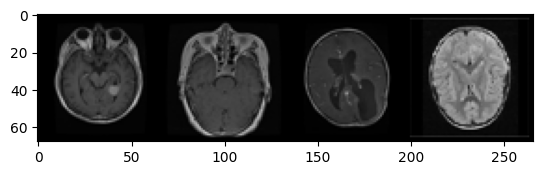

Glioma Glioma Glioma No Tumor


In [4]:
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images2, labels2 = next(dataiter)
print(images2.numpy().shape)

print(f"{type(images2)} : {(images2[0,0,0,0])}")

images = x_raw_tensor.reshape(-1, 1, 64, 64)  # Assuming images are grayscale and 64x64

print(f"{type(images)} : {(images[0,0,0,0])}")

labels = y_raw_tensor
print(labels)
print(images.numpy().shape)
# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels

print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 5) # changed from 3 to 1 for grayscale
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 5)
        self.conv3 = nn.Conv2d(6, 12, 5)
        
        self.fc1 = nn.Linear(12*9*9, 324)
        self.fc2 = nn.Linear(324, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

criterion = nn.CrossEntropyLoss()

net = Net().to(device) # puts variables in GPU meemory if available


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
# Training the network
bar = tqdm(range(200))
batch_size = 32
temp_loss_graph = []
count = 0
for epoch in bar:  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i in range(int(len(x_raw) / batch_size)):  # Assuming 4 samples per batch
        
        x_raw_temp = x_raw[i*batch_size:batch_size+i*batch_size].astype(np.float32)
        y_raw_temp = y_raw[i*batch_size:batch_size+i*batch_size]
        temp_x_raw_tensor = torch.from_numpy(x_raw_temp).reshape(-1, 1, 64, 64)
        temp_y_raw_tensor = torch.from_numpy(y_raw_temp)
        
        inputs = temp_x_raw_tensor.reshape(-1, 1, 64, 64).to(device)  # Move inputs to the same device as the model
        labels = temp_y_raw_tensor.to(device)  # Move labels to the same device as inputs
        
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    bar.set_description(f"loss = {(running_loss/32):.8f}")
    temp_loss_graph.append(running_loss/32)
    count+=1
    running_loss = 0.0

print("Finished Training")

loss = 0.00000014: 100%|██████████| 200/200 [00:57<00:00,  3.51it/s]

Finished Training


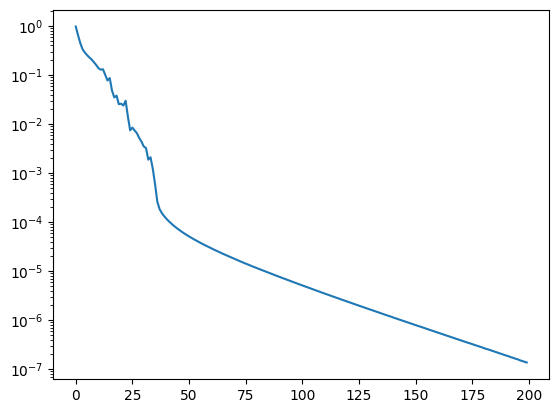

In [8]:
plt.semilogy(np.arange(0,count),temp_loss_graph)

In [9]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

In [10]:
# dataiter = iter(testloader)
# images, labels = next(dataiter)

# print images
# imshow(torchvision.utils.make_grid(images))
# print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  Glioma Glioma Glioma No Tumor


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i in range(len(x_raw)):
        # images, labels = data
        images = x_raw_tensor.reshape(-1, 1, 64, 64)  # Assuming images are grayscale and 64x64
        labels = y_raw_tensor
        # calculate outputs by running images through the network
        outputs = net(images[i:i+1])
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels[i:i+1].size(0)
        correct += (predicted == labels[i:i+1]).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")


Accuracy of the network on the 10000 test images: 100 %


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
print(total_pred)
print(correct_pred)

# again no gradients needed
with torch.no_grad():
    for i in range(len(x_raw)):
        # images, labels = data
        images = x_raw_tensor.reshape(-1, 1, 64, 64)  # Assuming images are grayscale and 64x64
        labels = y_raw_tensor
        outputs = net(images[i:i+1])
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels[i:i+1], predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(total_pred)
print(correct_pred)
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

{'Glioma': 0, 'No Tumor': 0}
{'Glioma': 0, 'No Tumor': 0}
{'Glioma': 1496, 'No Tumor': 504}
{'Glioma': 1496, 'No Tumor': 504}
Accuracy for class: Glioma is 100.0 %
Accuracy for class: No Tumor is 100.0 %


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


(332,)
torch.Size([332])
(332,)
torch.Size([332])
predicted :0 labels :1
predicted :1 labels :0
predicted :1 labels :0
predicted :0 labels :1
predicted :1 labels :0
predicted :1 labels :0
predicted :0 labels :1
predicted :1 labels :0
Acuracy : 97.59036144578313%


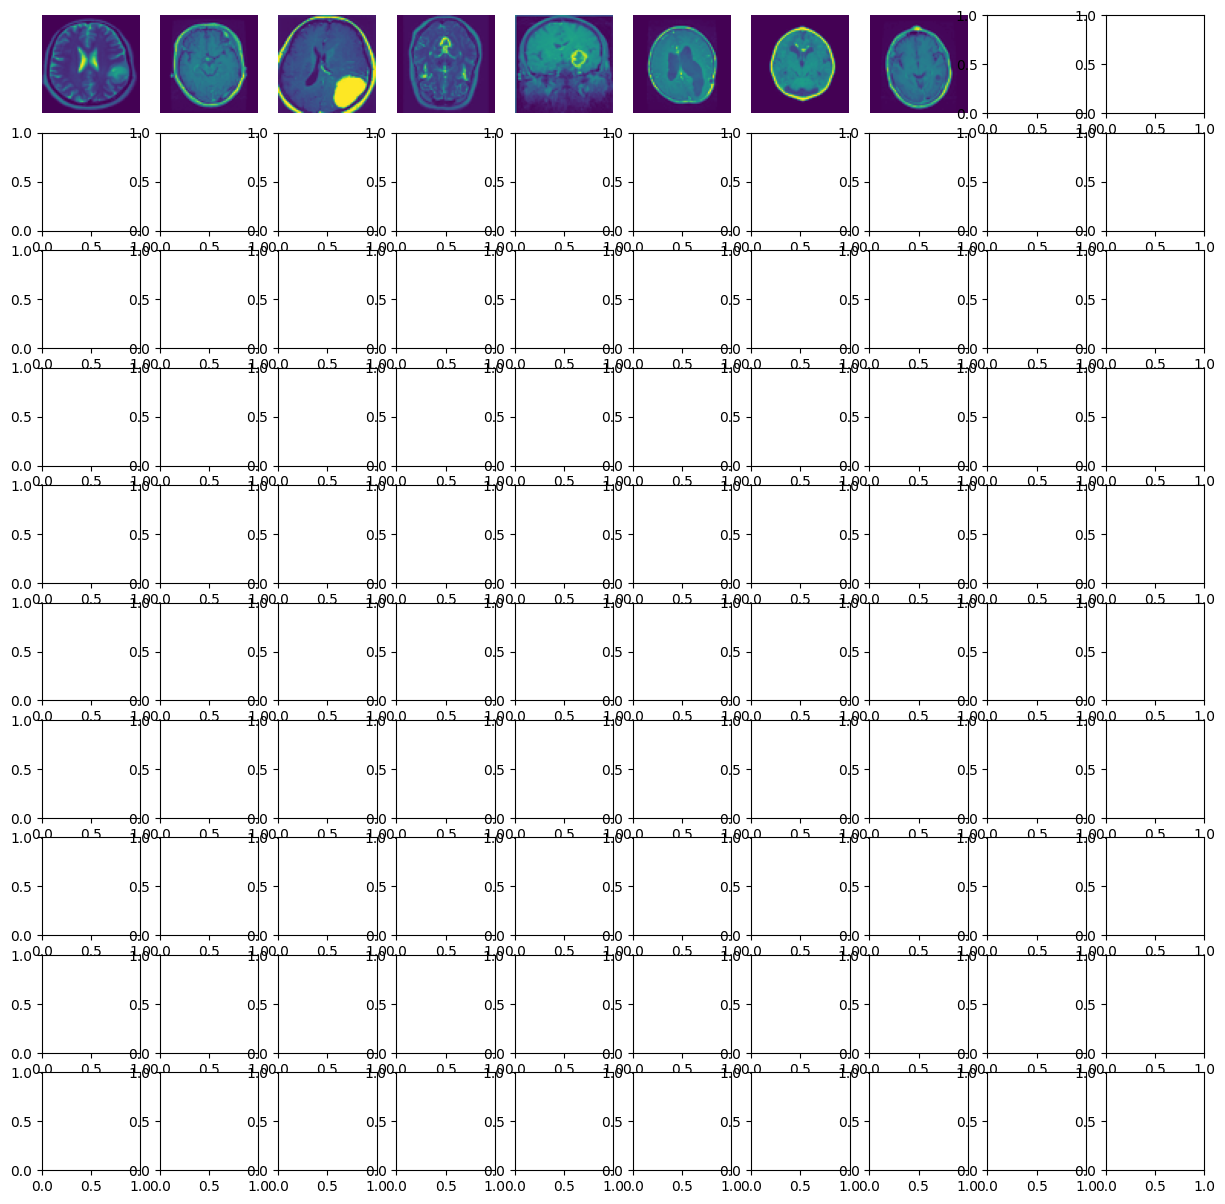

In [17]:

import ImageLoader as im
# x_raw2, y_raw2 = im.ImageLoader(path, -1, 2)
# x_raw_tensor = torch.from_numpy(x_raw2.astype(np.float32))
# y_raw_tensor = torch.from_numpy(y_raw2)
total = 0
total_correct = 0
failures = []
countf2 = 0
# for i in range(700):

print(y_Test.shape)

x_raw_temp = x_Test.astype(np.float32)
y_raw_temp = y_Test
temp_x_raw_tensor = torch.from_numpy(x_raw_temp).reshape(-1, 1, 64, 64)
temp_y_raw_tensor = torch.from_numpy(y_raw_temp)

inputs = temp_x_raw_tensor.reshape(-1, 1, 64, 64)  # Assuming images are grayscale and 64x64
labels = temp_y_raw_tensor

outputs = net(inputs)

_, predicted = torch.max(outputs, 1)

# print(f"predicted :{predicted}")
# print(f"labels    :{labels}")
# print(f"correct :{predicted==labels}\n")
print(predicted.shape)
print(y_Test.shape)
print(labels.shape)

for i in range(len((labels).tolist())):
    if (predicted==labels).tolist()[i]:
        total_correct += 1
    else:
        print(f"predicted :{predicted[i]} labels :{labels[i]}")
        failures.append(x_raw_temp[i])
        countf2+=1
    total += 1
print(f"Acuracy : {(total_correct/total)*100}%")

# print(net.state_dict())

fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for i in range(int(countf2/10)):
    for j in range(10):
        ax[i, j].imshow(failures[i*10+j].reshape(64, 64))
        ax[i, j].axis('off')
for i in range(countf2 % 10):
    ax[int(countf2/10), i].imshow(failures[int(countf2/10)*10+i].reshape(64, 64))
    ax[int(countf2/10), i].axis('off')




In [18]:

torch.save(net, "C:\\Users\\ruihe\\QCNN\\Model_Save\\net_model")
torch.save(net.state_dict(), "C:\\Users\\ruihe\\QCNN\\Model_Save\\net_model_state")
